# Sales Forecasting - Capstone Project

## Problem Statement

Rossmann is a European drug distributor which operates over 3,000 drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the store managers who are tasked with forecasting daily sales for the next six weeks. 
 
As expected, store sales are influenced by many factors, including promotional campaigns, competition, state holidays, seasonality, and locality.
 
With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with building a forecasting model to forecast the daily sales for the next six weeks. To help you with the same, you have been provided with historical sales data for 1,115 Rossmann stores.

### Data definition

The data is provided in two tables, stores and train. The store table contains the metadata for every single store including the following:
 
__Store__ - an Id that represents the store<br>
__StoreType__ - differentiates between 4 different store models: a, b, c, d<br>
__Assortment__ - describes an assortment level: a = basic, b = extra, c = extended<br>
__CompetitionDistance__ - describes thedistance in meters to the nearest competitor store<br>
__CompetitionOpenSince__[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened<br>
__Promo2__ - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating<br>
__Promo2Since__[Year/Week] - describes the year and calendar week when the store started participating in Promo2<br>
__PromoInterval__ - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb, May, Aug, Nov" means each round starts in February, May, August, November of any given year for that store<br>
<br>
The train table contains the sales data for individual stores at a daily level along with the details about the day<br>
<br>
__Store__ - a unique Id for each store<br>
__DayOfWeek__ - Describes the day of the week (1 - Monday till 7 - Sunday)<br>
__Date__ - Describes the date on the day<br>
__Sales__ - the turnover for any given day (this is what you are forecasting)<br>
__Customers__ - the number of customers on a given day<br>
__Open__ - an indicator for whether the store was open: 0 = closed, 1 = open<br>
__StateHoliday__ - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None<br>
__SchoolHoliday__ - indicates if the (Store, Date) was affected by the closure of public schools<br>
<br>
Since the company is just embarking on this project, the scope has been kept to nine key stores across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - 1,3,8,9,13,25,29,31 and 46.<br>
<br> 
While attempting to forecast sales, it is advisable to keep the following question in mind.<br>
<br> 
* Is the sales data non-stationary? If so, how do you find it and correct it?
* Is the data cointegrated? Which variables are cointegrated and how do you find them?
* What is the impact of the number of customers on sales?
* What is the impact of promo and promo2 variables on sales? How do you measure it?
* Forecast sales for the next 6 weeks? Report the accuracy of the model using MAPE.
<br>
<br>While you are solving the problem, the following steps can be used as a reference. Please note that you can take a different approach as well.<br>
<br> 
* Find outliers at the 99th percentile and remove them.
* Standardize the sales and number of customers variables before modelling.
* Determine if the data is stationary
* If stationary then apply Vector Autoregression Model.
* If non-stationary then specify the model in differences
* Make sales, promo2 and any other variables you think of as dependent variables.
* Check for cointegration using the Johansen test. 
* Predict sales for the next 6 weeks.

### importing libraries and dependencies

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [196]:
store_data = pd.read_csv('store.csv')
sales_data = pd.read_csv('train.csv', parse_dates=['Date'])

In [197]:
print('Store data rows %d and columns %d.' % store_data.shape)
print('Store Sales data rows %d and columns %d.' % sales_data.shape)

Store data rows 1115 and columns 10.
Store Sales data rows 1017209 and columns 9.


In [198]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [199]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


__No null values present in the sales data.__

In [200]:
sales_data.set_index(['Store'], inplace=True)
# Defining few useful variables
max_stores_count = store_data.shape[0]
key_stores = [1,3,8,9,13,25,29,31,46]

### EDA Utility Functions

In [201]:
def show_data_distribution():
    rows_for_each_store = []
    for i in range(max_stores_count):
        rows_for_each_store.append(sales_data.loc[i+1].shape[0])

    plt.figure(figsize=[12,6])
    plt.bar(range(0,max_stores_count), rows_for_each_store)
    plt.title("Data Distribution for each store")
    plt.show()
    
def showPlot(id, field_name, df=sales_data):
    plt.figure(figsize=[12,4])
    plt.plot(df.loc[id].Date, df.loc[id][field_name])
    plt.title("%s plot for store id: %d" % (field_name, id))
    plt.show()

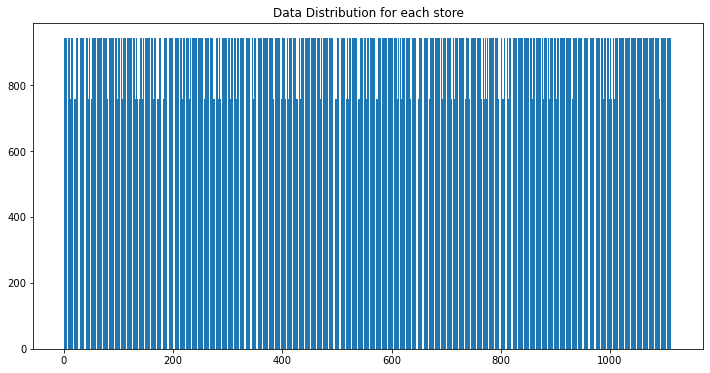

In [202]:
## Visualizing data to check how much data is missing
show_data_distribution()

__Observations__:
A lot of data is missing

In [203]:
### Refilling missing indices
df = sales_data.copy()

df.reset_index(inplace=True)
df = df.set_index('Date').groupby('Store').apply(lambda x: x.asfreq('D')).drop('Store', axis=1)
df.reset_index(inplace=True)
df.set_index(['Store'], inplace=True)

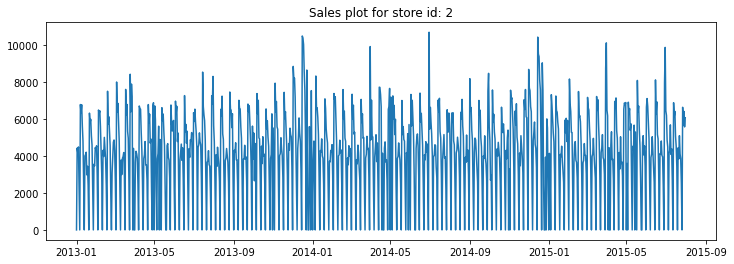

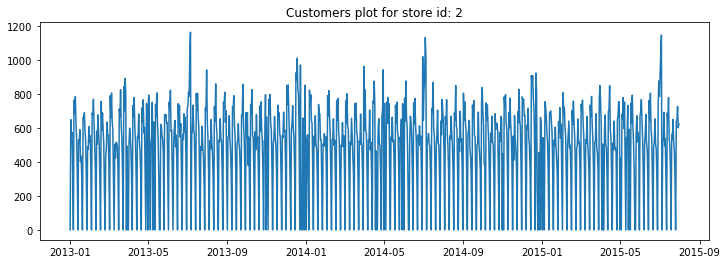

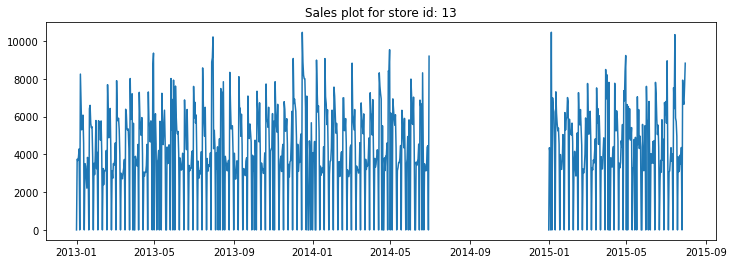

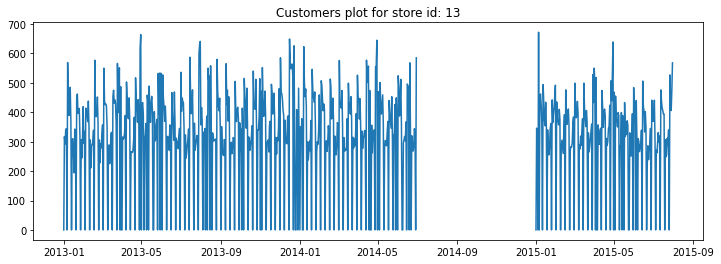

In [204]:
## Visualizing data for two particular stores
showPlot(2, 'Sales', df)
showPlot(2, 'Customers', df)

showPlot(13, 'Sales', df)
showPlot(13, 'Customers', df)

### imputation of missing data through linear interpolation

In [205]:
df['Sales'] = df.Sales.interpolate(method='linear')
df['Customers'] = df.Customers.interpolate(method='linear')

df.reset_index(inplace=True)
df.DayOfWeek = df.Date.apply(lambda x: (x.weekday() + 1))
df.Open.fillna(0, inplace=True)
df.Promo.fillna(0, inplace=True)
df.StateHoliday.fillna(0, inplace=True)
df.SchoolHoliday.fillna(0, inplace=True)
df.set_index(['Store'], inplace=True)
df.shape

(1050329, 8)

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050329 entries, 1 to 1115
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1050329 non-null  datetime64[ns]
 1   DayOfWeek      1050329 non-null  int64         
 2   Sales          1050329 non-null  float64       
 3   Customers      1050329 non-null  float64       
 4   Open           1050329 non-null  float64       
 5   Promo          1050329 non-null  float64       
 6   StateHoliday   1050329 non-null  object        
 7   SchoolHoliday  1050329 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 72.1+ MB


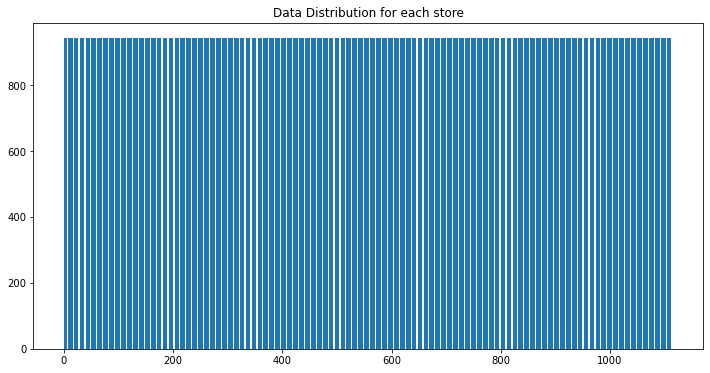

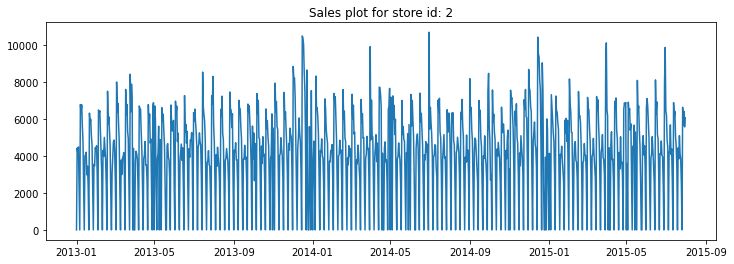

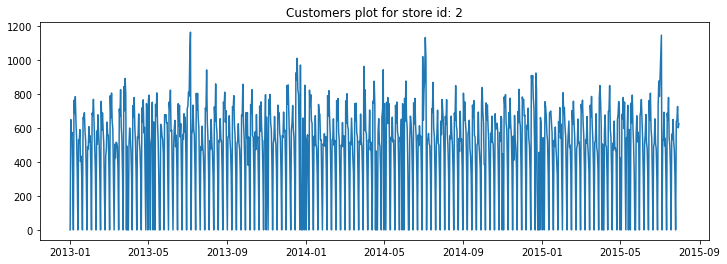

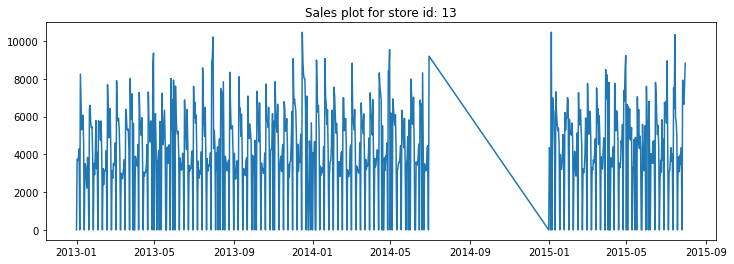

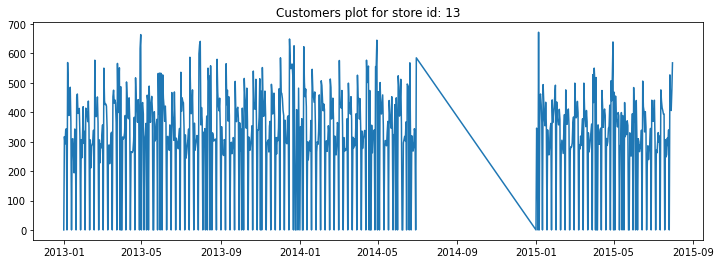

In [207]:
### Replacing old sale_data with the new with imputed vales
sales_data = df

### Distribution of data changes
show_data_distribution()

## Visualizing data for two particular stores after imputation
showPlot(2, 'Sales')
showPlot(2, 'Customers')

showPlot(13, 'Sales')
showPlot(13, 'Customers')

### Convert StateHoliday (categorical data) via Onehotencoding

In [208]:
StateHoliday_OnHotEncoded = pd.get_dummies(sales_data.StateHoliday)

sales_data['PublicHoliday'] = StateHoliday_OnHotEncoded.a
sales_data['EasterHoliday'] = StateHoliday_OnHotEncoded.b
sales_data['ChristmasHoliday'] = StateHoliday_OnHotEncoded.c

sales_data.drop(['StateHoliday'], inplace=True, axis=1)

In [209]:
sales_data.head()

,Date,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,PublicHoliday,EasterHoliday,ChristmasHoliday
Store,,,,,,,,,,
1,2013-01-01,2,0.0,0.0,0.0,0.0,1.0,1,0,0
1,2013-01-02,3,5530.0,668.0,1.0,0.0,1.0,0,0,0
1,2013-01-03,4,4327.0,578.0,1.0,0.0,1.0,0,0,0
1,2013-01-04,5,4486.0,619.0,1.0,0.0,1.0,0,0,0
1,2013-01-05,6,4997.0,635.0,1.0,0.0,1.0,0,0,0


In [210]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050329 entries, 1 to 1115
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Date              1050329 non-null  datetime64[ns]
 1   DayOfWeek         1050329 non-null  int64         
 2   Sales             1050329 non-null  float64       
 3   Customers         1050329 non-null  float64       
 4   Open              1050329 non-null  float64       
 5   Promo             1050329 non-null  float64       
 6   SchoolHoliday     1050329 non-null  float64       
 7   PublicHoliday     1050329 non-null  uint8         
 8   EasterHoliday     1050329 non-null  uint8         
 9   ChristmasHoliday  1050329 non-null  uint8         
dtypes: datetime64[ns](1), float64(5), int64(1), uint8(3)
memory usage: 99.4 MB


__Observations__:- <br>Sales and Customers are seemed to be two time series which can be endogeneous variables
<br>Sales: is the varibale of interest which needs to be predicted
<br>Open, promo, StateHoliday and SchollHoloday can be taken as exogeneous variables

### Stationarty Check

In [211]:
## Stationary check function
def stationarityCheck(store_id, field_name):
    # null hypothesis that the series is non-stationary
    # that means if p@5% < 0.05 then we can reject the null hypothesis
    # p > 0.05 -> Non-Stationay   and p < 0.05 ->Stationary
    fullerStats = adfuller(sales_data.loc[store_id][field_name])
    if(fullerStats[4]['5%'] < 0.05):
        return True
    else:
        return False

## Stationarity check for all the stores in one go
def checkStationarityForAllTheStores(field_name):
    ## Checking stationarity for Sales field
    non_stationarity_store_ids = [];
    for i in range(max_stores_count):
        if not stationarityCheck(i+1, field_name):
            non_stationarity_store_ids.append(i+1)

    if len(non_stationarity_store_ids) > 0:
        print("%d number of stores have non-stationary %s data" % (len(non_stationary_sales_for_stores), field_name))
    else:
        print("All the stores has stationary %s data" % field_name)
    return non_stationarity_store_ids

In [212]:
print("Observations:")
checkStationarityForAllTheStores('Sales')
checkStationarityForAllTheStores('Customers')

Observations:
All the stores has stationary Sales data
All the stores has stationary Customers data


[]

### Cointegration test

In [213]:
def coninttest(storeId):
    joh_model1 = coint_johansen(sales_data.loc[storeId][['Sales','Customers']],-1,1)
    traces = joh_model1.lr1
    cvts = joh_model1.cvt
    for index, conf_inter in enumerate(["90%", "95%", "99%"]):
        r = 0
        for i in range(2):
            if traces[i] > cvts[i, index]:
                r = i + 1
        print("Store Id: %d, Rank @%s confidence interval: %d" % (storeId, conf_inter, r))

In [214]:
coninttest(1)
coninttest(13)

Store Id: 1, Rank @90% confidence interval: 2
Store Id: 1, Rank @95% confidence interval: 2
Store Id: 1, Rank @99% confidence interval: 2
Store Id: 13, Rank @90% confidence interval: 2
Store Id: 13, Rank @95% confidence interval: 2
Store Id: 13, Rank @99% confidence interval: 2


__Observation__:
There is no cointegration between Sales and Customer field data

### Evaluate value of p and q for the VARMAX model

In [215]:
### Plotting acf and pacf plots for two particular
def acf_and_pacf(storeId):
    plt.figure(figsize=[12,4])
    plot_pacf(sales_data.loc[storeId].Sales, ax=plt.gca(), lags=30)
    plt.title('PACF plot for %d strore' % storeId)
    plt.show()
    plt.figure(figsize=[12,4])
    plot_acf(sales_data.loc[storeId].Sales, ax=plt.gca(), lags=30)
    plt.title('ACF plot for %d strore' % storeId)
    plt.show()

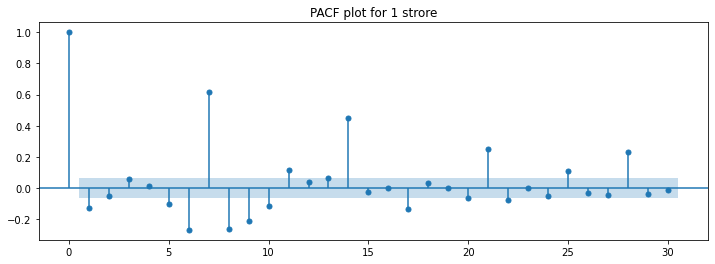

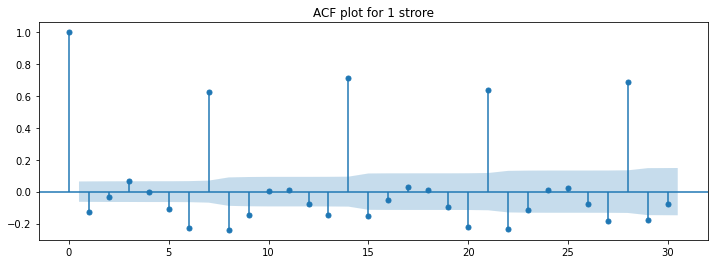

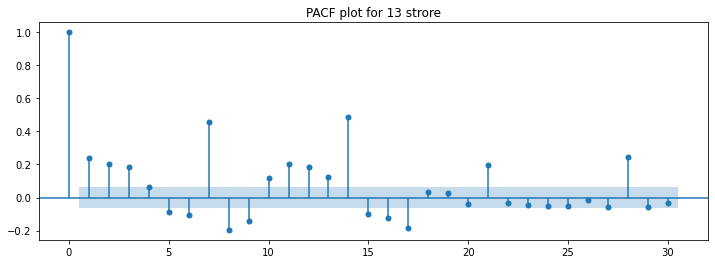

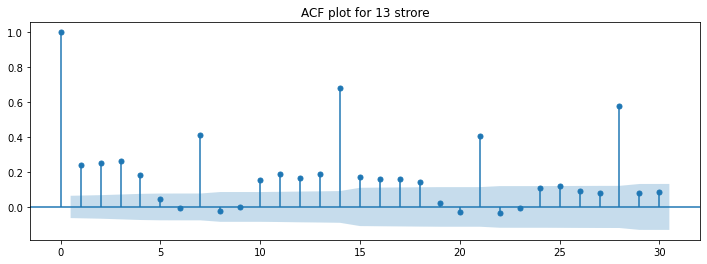

In [216]:
acf_and_pacf(1)
acf_and_pacf(13)

## Model building

### Train-Test Split

In [217]:
### Splitting data (Need to forecast for 6 weeks = 42 days i.e. after 2015-06-19)
train_data = sales_data[sales_data.Date <= '2015-06-19']
test_data = sales_data[sales_data.Date > '2015-06-19']

print("Train data rows after split is %d" % train_data.shape[0])
print("Test data rows after split is %d" % test_data.shape[0])

Train data rows after split is 1003499
Test data rows after split is 46830


### Scaling data and Model building

In [224]:
# Scaling data for model building
def scale_train(df, field_names):
    scaler = StandardScaler()
    df[field_names] = scaler.fit_transform(df[field_names])
    return scaler

def scale_test(df, field_names, scaler):
    df[field_names] = scaler.transform(df[field_names])

# Build model and return trained model instance
def buildModel(df, p, q, exog): 
    mod = sm.tsa.VARMAX(df[['Sales', 'Customers']], order=(p,q), trend='n', exog=df[exog])
    res = mod.fit(maxiter=1000, disp=False)
    return res

def plot_predictions(test_df, predictions, store_id):
    plt.figure(figsize=[16,4])
    plt.plot(test_df['Sales'], label='test')
    plt.plot(predictions['Sales'], label='predictions')
    plt.legend(loc='best')
    plt.title('VARMAX Sales forecst model for store id %d' % store_id )
    plt.show()
    
def calculate_mape(test_df, predictions):
    abs_values = np.abs((test_df.Sales - predictions.Sales)/test_df.Sales)
    mape= np.round(np.mean(abs_values)*100, 2)
    return mape

In [232]:
exog = ["Open","Promo","SchoolHoliday","PublicHoliday","EasterHoliday","ChristmasHoliday","DayOfWeek"]

#def for store_id in [1]:
def buildModel(store_id, p, q):
    train_df = train_data.loc[store_id].copy()
    test_df = test_data.loc[store_id].copy()
    train_df.set_index(['Date'], inplace=True)
    test_df.set_index(['Date'], inplace=True)
    
    # Scaling train data
    scaler = scale_train(train_df, ['Sales', 'Customers'])
    # Model building
    #model = buildModel(train_df, 1,1, exog)
    model = sm.tsa.VARMAX(df[exog], order=(p,q), trend='n', exog=df[exog])
    model = model.fit(maxiter=1000, disp=False)
    
    # Predictions 
    scale_test(test_df, ['Sales', 'Customers'], scaler)
    predictions = model.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, exog = test_df[exog] )
    plot_predictions(test_df, predictions, store_id)
    return calculate_mape(test_df, predictions)

In [ ]:
mape_df = pd.Dataframe( index=key_stores)
mape buildModel(1, 1, 1)

In [ ]:
mape_df = pd.Dataframe( index=key_stores)
mape_df